### LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from tqdm import tqdm

### CARGA DE DATOS

In [4]:
df= pd.read_excel("datosRed.xlsx")

### LIMPIEZA

In [ ]:
df['PERSONA'] = df['PERSONA'].astype(str).str.strip().str.upper()
df['AÑO'] = df['AÑO'].astype(int)
df['TIPO DE SERVICIO'] = df['TIPO DE SERVICIO'].astype(str).str.strip().str.upper()
df['NOMBRE DE LA TAREA'] = df['NOMBRE DE LA TAREA'].astype(str).str.strip().str.upper()
df['MODALIDAD'] = df['MODALIDAD'].astype(str).str.strip().str.upper()
df['COMPLEJIDAD'] = df['COMPLEJIDAD'].astype(str).str.strip().str.upper()

df['UNIDAD_CONSUMO'] = df['TIPO DE SERVICIO'] + '_' + df['NOMBRE DE LA TAREA']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AÑO                 10384 non-null  int64 
 1   PERSONA             10384 non-null  object
 2   TIPO DE SERVICIO    10384 non-null  object
 3   NOMBRE DE LA TAREA  10384 non-null  object
 4   MODALIDAD           10384 non-null  object
 5   COMPLEJIDAD         10384 non-null  object
 6   UNIDAD_CONSUMO      10384 non-null  object
dtypes: int64(1), object(6)
memory usage: 568.0+ KB


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.head()

,AÑO,PERSONA,TIPO DE SERVICIO,NOMBRE DE LA TAREA,MODALIDAD,COMPLEJIDAD,UNIDAD_CONSUMO
0,2019,ID_1,SERV_1,TAREA_1.1,PRESENCIAL,BAJA,SERV_1_TAREA_1.1
1,2019,ID_2,SERV_1,TAREA_1.1,PRESENCIAL,BAJA,SERV_1_TAREA_1.1
2,2019,ID_3,SERV_1,TAREA_1.1,PRESENCIAL,BAJA,SERV_1_TAREA_1.1
3,2019,ID_4,SERV_1,TAREA_1.1,PRESENCIAL,BAJA,SERV_1_TAREA_1.1
4,2019,ID_5,SERV_1,TAREA_1.1,PRESENCIAL,BAJA,SERV_1_TAREA_1.1


In [9]:
df.tail()

,AÑO,PERSONA,TIPO DE SERVICIO,NOMBRE DE LA TAREA,MODALIDAD,COMPLEJIDAD,UNIDAD_CONSUMO
10365,2024,ID_5081,SERV_4,TAREA_4.1,PRESENCIAL,MEDIANA,SERV_4_TAREA_4.1
10374,2024,ID_7,SERV_4,TAREA_4.1,PRESENCIAL,MEDIANA,SERV_4_TAREA_4.1
10377,2024,ID_5089,SERV_5,TAREA_5.2,PRESENCIAL,MEDIANA,SERV_5_TAREA_5.2
10378,2024,ID_5083,SERV_5,TAREA_5.2,PRESENCIAL,MEDIANA,SERV_5_TAREA_5.2
10379,2024,ID_4836,SERV_4,TAREA_4.3,PRESENCIAL,BAJA,SERV_4_TAREA_4.3


### CREACION DE RED

In [ ]:
def build_annual_network(df_year):
    clientes = df_year['PERSONA'].astype('category')
    servicios = df_year['UNIDAD_CONSUMO'].astype('category')

    row = clientes.cat.codes
    col = servicios.cat.codes
    data = np.ones(len(df_year))

    M = csr_matrix((data, (row, col)), shape=(clientes.cat.categories.size, servicios.cat.categories.size))
    
    co_matrix = M.dot(M.T)

    G = nx.Graph()
    G.add_nodes_from(clientes.cat.categories)

    coo = co_matrix.tocoo()
    for i, j, w in zip(coo.row, coo.col, coo.data):
        if i < j and w > 0:
            G.add_edge(clientes.cat.categories[i], clientes.cat.categories[j], weight=int(w))
    
    return G

In [28]:
redes_anuales = {}
for year in sorted(df['AÑO'].unique()):
    df_year = df[df['AÑO'] == year].copy()
    G_t = build_annual_network(df_year)
    redes_anuales[year] = G_t
    print(f"{year}: {G_t.number_of_nodes()} nodos, {G_t.number_of_edges()} enlaces")

2019: 298 nodos, 44253 enlaces
2020: 806 nodos, 163332 enlaces
2021: 2386 nodos, 1284882 enlaces
2022: 1557 nodos, 557238 enlaces
2023: 711 nodos, 98563 enlaces
2024: 375 nodos, 23155 enlaces


### RESULTADOS

In [ ]:
resultados_metricas = []

for year, G in tqdm(redes_anuales.items(), desc="Cálculo de métricas"):
    N = G.number_of_nodes()
    M = G.number_of_edges()

    if N > 1:
        avg_degree = 2 * M / N
        density = nx.density(G)
        clustering = nx.average_clustering(G, weight='weight')

        giant = max(nx.connected_components(G), key=len)
        G_gc = G.subgraph(giant)

        avg_path = nx.average_shortest_path_length(G_gc)
        diameter = nx.diameter(G_gc)
    else:
        avg_degree = density = clustering = avg_path = diameter = 0

    resultados_metricas.append({
        'AÑO': year,
        'N_Nodos': N,
        'N_Enlaces': M,
        'Grado_Medio': round(avg_degree, 3),
        'Densidad': round(density, 5),
        'Clustering': round(clustering, 3),
        'Distancia_Media': round(avg_path, 3),
        'Diametro': diameter
    })

df_metricas = pd.DataFrame(resultados_metricas)
display(df_metricas)

Cálculo de métricas: 100%|██████████| 6/6 [2:00:05<00:00, 1200.90s/it]  


,AÑO,N_Nodos,N_Enlaces,Grado_Medio,Densidad,Clustering,Distancia_Media,Diametro
0,2019,298,44253,297.000,1.00000,1.000,1.000,1
1,2020,806,163332,405.290,0.50347,0.104,1.504,4
2,2021,2386,1284882,1077.018,0.45158,0.109,1.551,3
3,2022,1557,557238,715.784,0.46002,0.114,1.596,4
4,2023,711,98563,277.252,0.39050,0.087,1.625,4
5,2024,375,23155,123.493,0.33020,0.084,1.704,4


In [10]:
def plot_degree_distribution(G, year):
    degs = [d for n, d in G.degree()]
    counts = pd.Series(degs).value_counts().sort_index()
    pk = counts / len(degs)

    plt.figure(figsize=(6, 4))
    plt.loglog(pk.index, pk.values, 'o-', alpha=0.7)
    plt.title(f'Distribución de Grados P(k) - {year}')
    plt.xlabel('Grado (k)')
    plt.ylabel('P(k)')
    plt.grid(True, which="both", ls="--")
    plt.show()

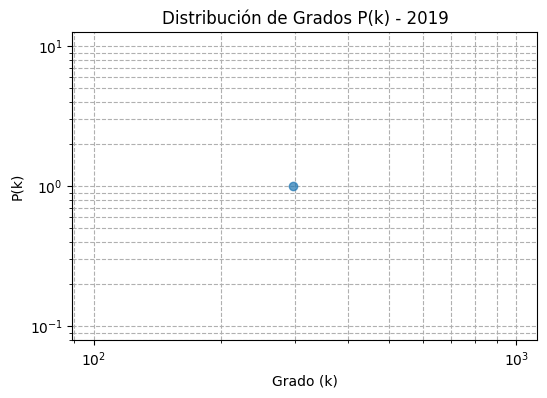

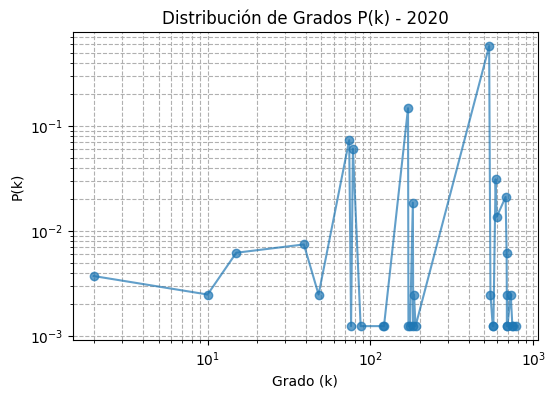

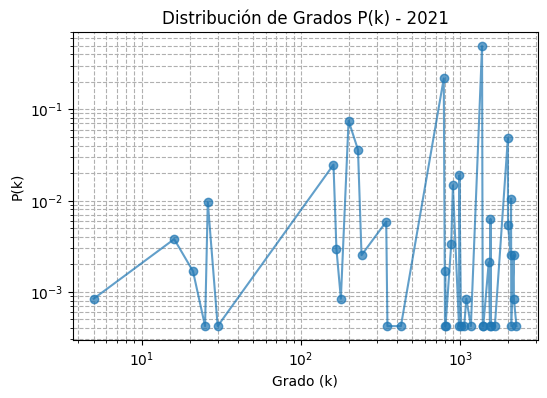

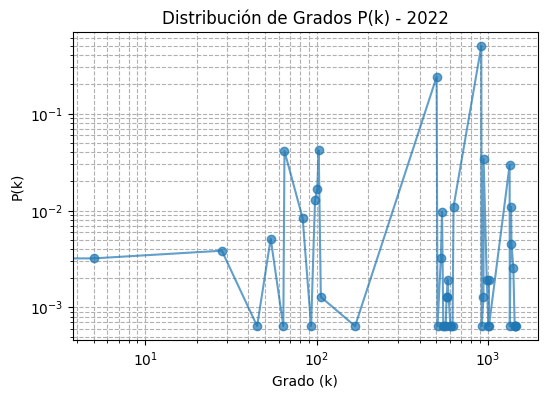

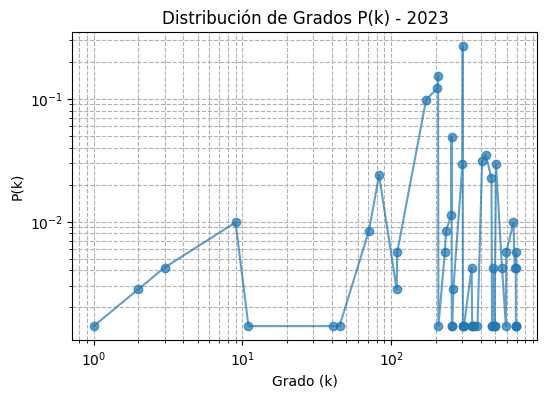

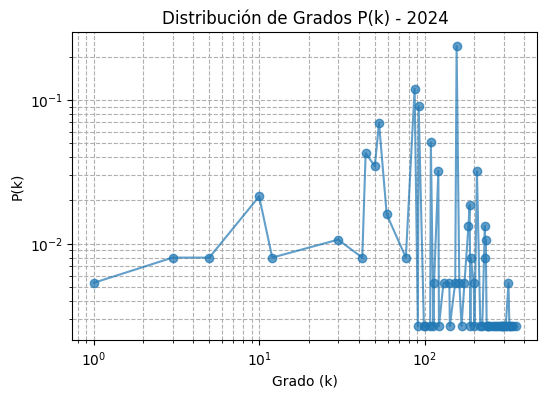

In [18]:
plot_degree_distribution(redes_anuales[2019], 2019)
plot_degree_distribution(redes_anuales[2020], 2020)
plot_degree_distribution(redes_anuales[2021], 2021)
plot_degree_distribution(redes_anuales[2022], 2022)
plot_degree_distribution(redes_anuales[2023], 2023)
plot_degree_distribution(redes_anuales[2024], 2024)

In [13]:
df_metricas.to_csv("metricas_redes_anuales.csv", index=False)
print("Resultados exportados: metricas_redes_anuales.csv")

Resultados exportados: metricas_redes_anuales.csv
